In [10]:
pip install fuzzywuzzy python-Levenshtein

In [11]:
pip install optuna

In [12]:
#pip install "pytorch-tabular[all]" transformers datasets torch xgboost scikit-learn==1.5.0 pytorch-lightning jupyter-tensorboard plotly fastapi
# import pytorch_lightning as pl
# from pytorch_lightning.loggers import CSVLogger
# logger = CSVLogger("", name="tab_transformer")

In [56]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
import optuna
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset


from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, RocCurveDisplay, classification_report, ConfusionMatrixDisplay,
    roc_curve, fbeta_score)
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder)
from sklearn.utils import resample, class_weight
from imblearn.over_sampling import SMOTE, SMOTENC

import shap
import joblib
import math

from fuzzywuzzy import fuzz, process
import warnings
warnings.filterwarnings('ignore')

# **Разведочный анализ**

In [14]:
df1 = pd.read_csv('applications.csv')
df2 = pd.read_csv('features.csv')
df3 = pd.read_csv('data.csv')

In [15]:
df1

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success
0,4921736,03/07/2020,2000,60,Employed - full time,Unexpected bills,0
1,1241981,04/02/2020,3000,60,Employed - full time,Starting new bussniess,0
2,5751748,02/08/2020,20000,60,Employed - full time,Business capital,0
3,7163425,23/09/2020,20000,60,Self employed,New business venture,0
4,227377,01/01/2020,5000,36,Employed - full time,car,0
...,...,...,...,...,...,...,...
8842,8681053,17/11/2020,5000,60,Employed - full time,Wedding,0
8843,8768469,20/11/2020,8000,24,Employed - full time,Wedding,0
8844,8794971,22/11/2020,1000,36,Employed - full time,Wedding deposit,0
8845,8875138,24/11/2020,10000,60,Self employed,Wedding,0


In [16]:
df2

,UID,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_TimeSinceMostRecentDefault,ALL_WorstPaymentStatusActiveAccounts
0,216009,227,12,14,11,0,3,0,3,71.36,9292,9292,-1,7
1,217537,49,10,7,6,1,3,1,1,29.33,4592,4592,-1,7
2,221803,134,0,12,11,0,3,5,1,32.33,2737,2737,-1,7
3,222260,227,2,39,12,0,2,2,27,41.56,9229,9229,-1,7
4,222848,132,2,99,11,8,0,9,88,43.34,15443,15443,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,9679857,399,13,23,16,0,0,0,7,118.09,187302,23018,-1,0
8843,9680193,217,23,5,4,0,0,0,1,85.40,264,264,-1,0
8844,9681405,3,1,2,2,0,0,2,0,2.00,0,0,-1,0
8845,9684198,178,15,23,17,0,1,0,6,66.91,10071,10071,-1,7


In [17]:
df3

,Name,Description
0,UID,unique identifier
1,Application Date,Date of loan application
2,Amount,Amount requested by applicant
3,Term,Repayment period requested by applicant
4,Employment Type,Stated employment
5,LoanPurpose,Purpose of loan
6,Success,Applicant successful
7,ALL_AgeOfOldestAccount,Age of oldest accounts
8,ALL_AgeOfYoungestAccount,Age of youngest accounts
9,ALL_Count,No. of accounts


## Описание столбцов:

| Название                              | Описание                                           |
| ------------------------------------- | -------------------------------------------------- |
| UID                                   | Уникальный идентификатор                           |
| Application Date                      | Дата подачи заявки на кредит                       |
| Amount                                | Запрошенная сумма                                  |
| Term                                  | Запрошенный срок погашения                         |
| Employment Type                       | Заявленный тип занятости                           |
| LoanPurpose                           | Цель кредита                                       |
| Success                               | Успешность заявки                                  |
| ALL\_AgeOfOldestAccount               | Возраст самого старого счёта                       |
| ALL\_AgeOfYoungestAccount             | Возраст самого нового счёта                        |
| ALL\_Count                            | Количество счетов                                  |
| ALL\_CountActive                      | Количество активных счетов                         |
| ALL\_CountClosedLast12Months          | Количество закрытых за последние 12 месяцев счетов |
| ALL\_CountDefaultAccounts             | Количество просроченных счетов                     |
| ALL\_CountOpenedLast12Months          | Количество открытых за последние 12 месяцев счетов |
| ALL\_CountSettled                     | Количество урегулированных счетов                  |
| ALL\_MeanAccountAge                   | Средний возраст счетов                             |
| ALL\_SumCurrentOutstandingBal         | Суммарный текущий остаток по счетам                |
| ALL\_SumCurrentOutstandingBalExcMtg   | Суммарный остаток по счетам, исключая ипотеку      |
| ALL\_TimeSinceMostRecentDefault       | Кол-во месяцев с последней просрочкой              |
| ALL\_WorstPaymentStatusActiveAccounts | Худший статус платежа по активным счетам           |


## Объединение двух датасетов по UID

In [18]:
df = pd.merge(df1, df2, on='UID', how='inner')
df

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_TimeSinceMostRecentDefault,ALL_WorstPaymentStatusActiveAccounts
0,4921736,03/07/2020,2000,60,Employed - full time,Unexpected bills,0,162,17,18,12,0,0,0,6,70.94,68555,15019,-1,0
1,1241981,04/02/2020,3000,60,Employed - full time,Starting new bussniess,0,266,30,14,10,0,4,0,4,104.79,2209,2209,-1,7
2,5751748,02/08/2020,20000,60,Employed - full time,Business capital,0,90,52,4,2,0,1,0,2,68.25,5108,5108,-1,7
3,7163425,23/09/2020,20000,60,Self employed,New business venture,0,163,19,14,6,1,1,0,8,67.50,25738,25738,-1,0
4,227377,01/01/2020,5000,36,Employed - full time,car,0,129,2,38,19,4,9,8,19,56.45,5801,5801,-1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,8681053,17/11/2020,5000,60,Employed - full time,Wedding,0,164,2,22,16,2,0,5,6,52.36,10968,10968,-1,0
8843,8768469,20/11/2020,8000,24,Employed - full time,Wedding,0,275,20,7,4,1,1,0,3,73.57,2204,2204,-1,7
8844,8794971,22/11/2020,1000,36,Employed - full time,Wedding deposit,0,145,8,14,13,0,0,1,1,44.14,6786,6786,-1,0
8845,8875138,24/11/2020,10000,60,Self employed,Wedding,0,12,7,4,3,1,0,3,1,9.25,9398,9398,-1,0


## Удаление неинформативных признаков

In [19]:
df.drop(['UID', 'ALL_TimeSinceMostRecentDefault', 'ApplicationDate', 'ALL_CountDefaultAccounts',
         'ALL_Count', 'ALL_AgeOfOldestAccount'], axis=1, inplace=True)

## Обработка категориальных признаков

In [20]:
# Количество уникальных значений категориальных признаков
print(df.select_dtypes(include='object').nunique())

EmploymentType       4
LoanPurpose       2444
dtype: int64


In [21]:
# Выявление уникальных категорий
for column in df.columns:
    if df[column].dtype == 'object':
        print(df[column].value_counts(), '\n')

EmploymentType
Employed - full time    7714
Employed - part time     570
Self employed            418
Retired                  145
Name: count, dtype: int64 

LoanPurpose
Car                   978
Consolidation         581
car                   373
Debt consolidation    357
Other                 310
                     ... 
household carpets       1
homeipovement           1
house work              1
Refurbishments          1
House inprovements      1
Name: count, Length: 2444, dtype: int64 



In [22]:
df['LoanPurpose'] = df['LoanPurpose'].str.lower()

In [23]:
df['LoanPurpose'].unique()

array(['unexpected bills', 'starting new bussniess', 'business capital',
       ..., 'wedding costs', 'weddings', 'wedding deposit'], dtype=object)

<Axes: xlabel='LoanPurpose'>

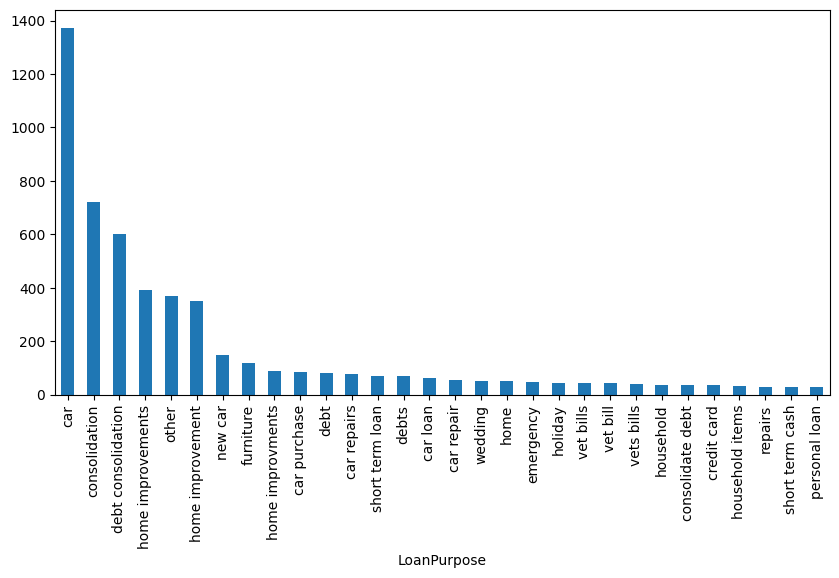

In [24]:
df['LoanPurpose'].value_counts().head(30).plot(kind='bar', figsize=(10, 5))

In [25]:
# Устанавливаем порог схожести в 80 (достаточно строгое)
unique_purposes = df['LoanPurpose'].unique()

standardized = {}
threshold = 80

for purpose in unique_purposes:
    match = process.extractOne(purpose, list(standardized.keys()), scorer=fuzz.token_sort_ratio)
    if match and match[1] >= threshold:
        standardized[purpose] = standardized[match[0]]
    else:
        standardized[purpose] = purpose

df['LoanPurpose'] = df['LoanPurpose'].map(standardized)

In [26]:
df['LoanPurpose'].unique()

array(['unexpected bills', 'starting new bussniess', 'business capital',
       ..., 'wedding expenses', 'wedding costs', 'wedding deposit'],
      dtype=object)

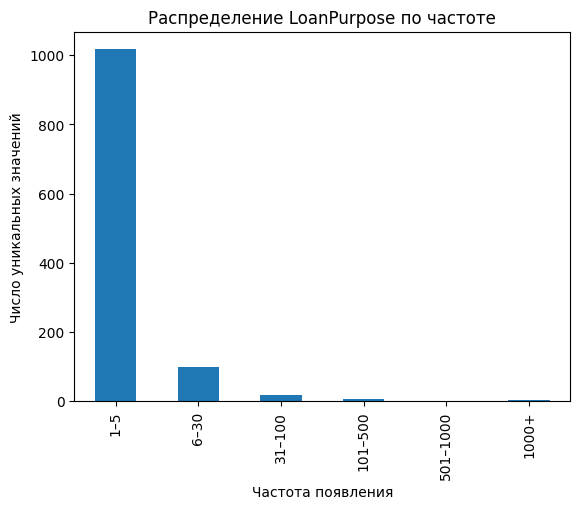

In [27]:
counts = df['LoanPurpose'].value_counts()

max_count = counts.max()
bins = [0, 5, 30, 100, 500, 1000, max_count + 1]
labels = ['1–5', '6–30', '31–100', '101–500', '501–1000', '1000+']

binned = pd.cut(counts, bins=bins, labels=labels, right=True)
binned.value_counts().sort_index().plot(kind='bar', title='Распределение LoanPurpose по частоте')
plt.ylabel('Число уникальных значений')
plt.xlabel('Частота появления')
plt.show()

In [28]:
# Заменяем редкие значения на 'other' (менее 15 повторений)
value_counts = df['LoanPurpose'].value_counts()

common = value_counts[value_counts >= 15].index
df['LoanPurpose'] = df['LoanPurpose'].apply(lambda x: x if x in common else 'other')

In [29]:
df['LoanPurpose'].value_counts()

,count
LoanPurpose,
other,2453
consolidation,1695
car,1383
car improvements,1009
debt bills,159
debt,154
new car,154
car repairs,134
furniture,124


In [30]:
df['LoanPurpose'].unique()

array(['other', 'car', 'new car', 'car insurance', 'car loan', 'caravan',
       'car repairs', 'buy car', 'car purchase', 'car bill', 'motorcycle',
       'pay off  loan /car', 'motorbike', 'van', 'vehicle', 'debt/car',
       'car improvements', 'car & consolidate', 'car,credit car bills',
       'personal car', 'consolidation', 'debt',
       'credit card consolidation', 'consolidate other debts',
       'credit cards', 'pay off credit cards', 'consolidation and car',
       'pay off debt', 'debt bills', 'holiday', 'moving house', 'house',
       'house repairs', 'home', 'house deposit', 'house items',
       'refurbishment', 'household stuff', 'house goods', 'medical',
       'furniture', 'rent', 'short term cash', 'unexpected expense',
       'engagement ring', 'emergency expenses', 'emergency', 'repairs',
       'investment', 'medical bill', 'bike', 'baby', 'wedding'],
      dtype=object)

In [31]:
df.isnull().sum()

,0
Amount,0
Term,0
EmploymentType,0
LoanPurpose,0
Success,0
ALL_AgeOfYoungestAccount,0
ALL_CountActive,0
ALL_CountClosedLast12Months,0
ALL_CountOpenedLast12Months,0
ALL_CountSettled,0


## Обработка числовых значений

In [32]:
df.describe()

,Amount,Term,Success,ALL_AgeOfYoungestAccount,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
count,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8.847000e+03,8847.000000,8847.000000
mean,7560.692438,41.985080,0.104216,8.587431,9.258506,1.589691,2.453487,8.231491,57.285159,5.416258e+04,12858.636148,2.057647
std,5309.138911,16.139168,0.305558,13.081866,4.896900,2.611921,2.964837,11.419963,29.132180,1.074432e+05,17756.568825,3.139938
min,500.000000,12.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000
25%,3000.000000,24.000000,0.000000,2.000000,6.000000,0.000000,1.000000,2.000000,38.770000,3.396000e+03,2438.000000,0.000000
50%,6500.000000,48.000000,0.000000,5.000000,9.000000,1.000000,2.000000,5.000000,53.120000,1.267000e+04,8336.000000,0.000000
75%,10000.000000,60.000000,0.000000,10.000000,12.000000,2.000000,3.000000,10.000000,71.530000,6.171250e+04,17990.500000,7.000000
max,20000.000000,60.000000,1.000000,258.000000,43.000000,60.000000,62.000000,215.000000,304.000000,4.004808e+06,581415.000000,7.000000


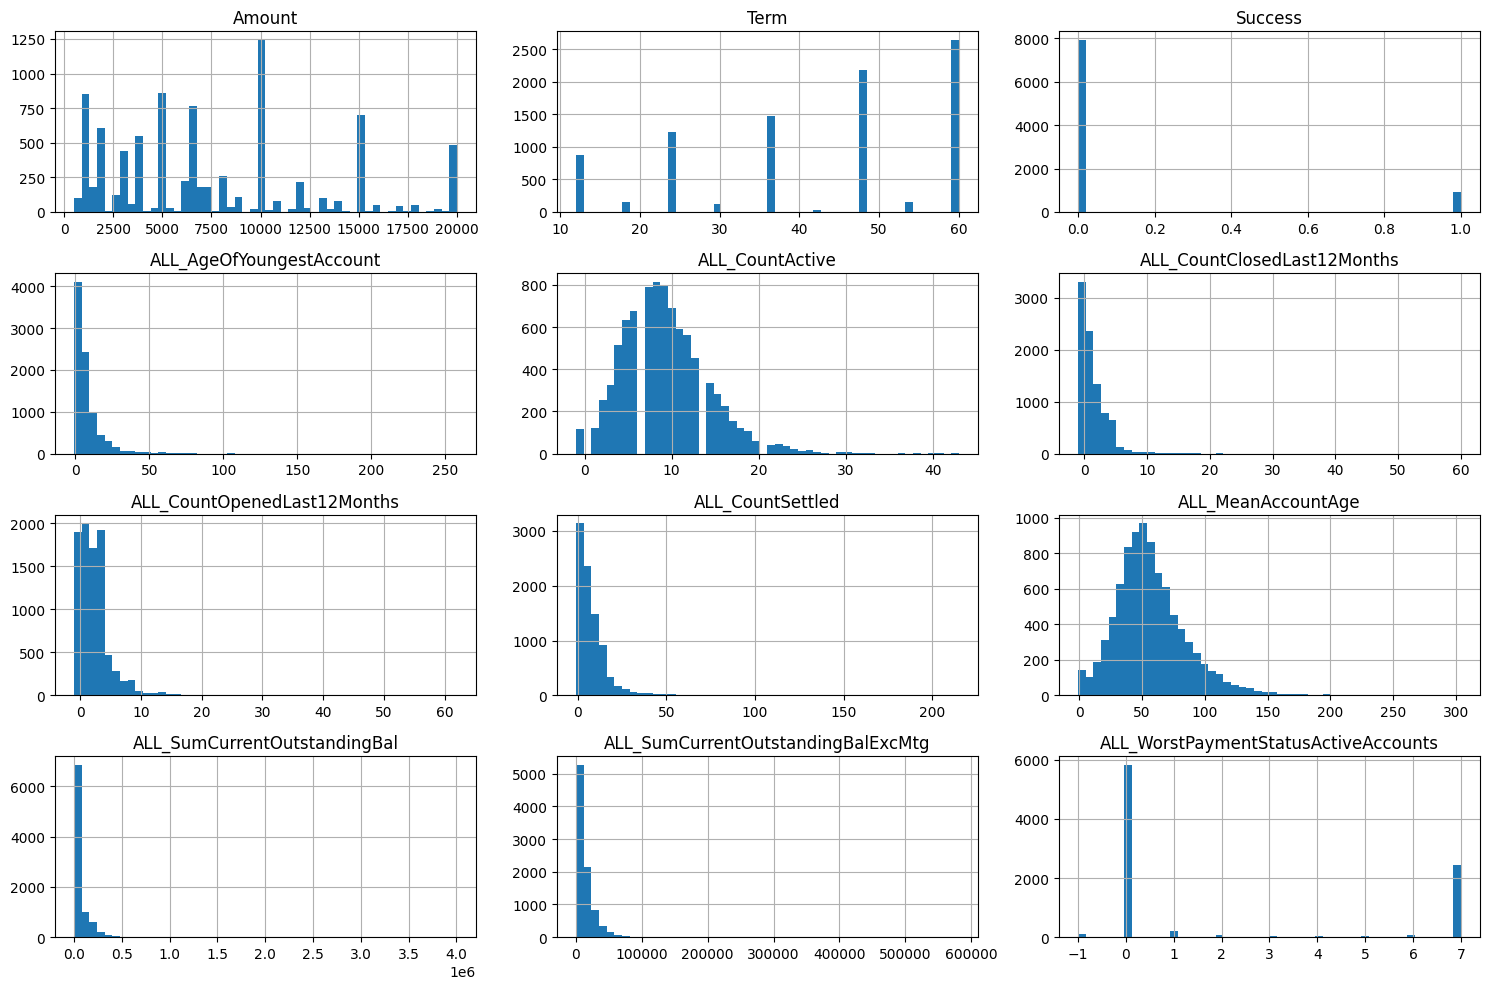

In [33]:
# Заметны выбросы (правый хвост)
df.hist(bins=50, figsize=(15, 10))
plt.tight_layout()

In [34]:
lower = df['Amount'].quantile(0.025)
upper = df['Amount'].quantile(0.975)

In [35]:
outliers = df[(df['Amount'] < lower) | (df['Amount'] > upper)]
normal = df[(df['Amount'] >= lower) & (df['Amount'] <= upper)]

In [36]:
print("Выбросы:")
print(outliers['Success'].value_counts(normalize=True))

print("\nНормальные значения:")
print(normal['Success'].value_counts(normalize=True))

Выбросы:
Success
0    0.989899
1    0.010101
Name: proportion, dtype: float64

Нормальные значения:
Success
0    0.894719
1    0.105281
Name: proportion, dtype: float64


****
Очевидно, что выбросы не определяют дефолтных клиентов, а посему могут быть удалены.  
****

In [37]:
# Удаляем выбросы (оставляем лишь объекты 95% квантиля)
num_cols = df.select_dtypes(include=['number']).columns

for col in num_cols:
    upper = df[col].quantile(0.95)
    df = df[df[col] <= upper]

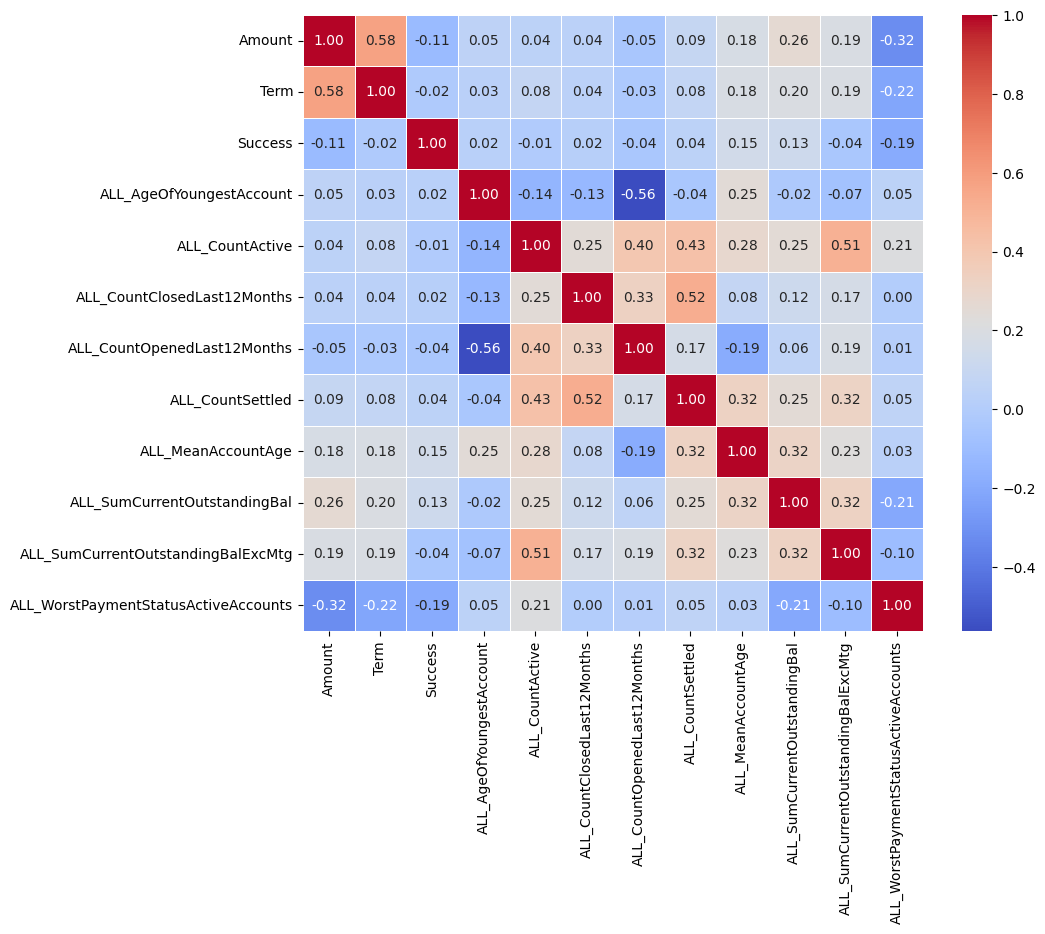

In [38]:
numerical_features = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.show()

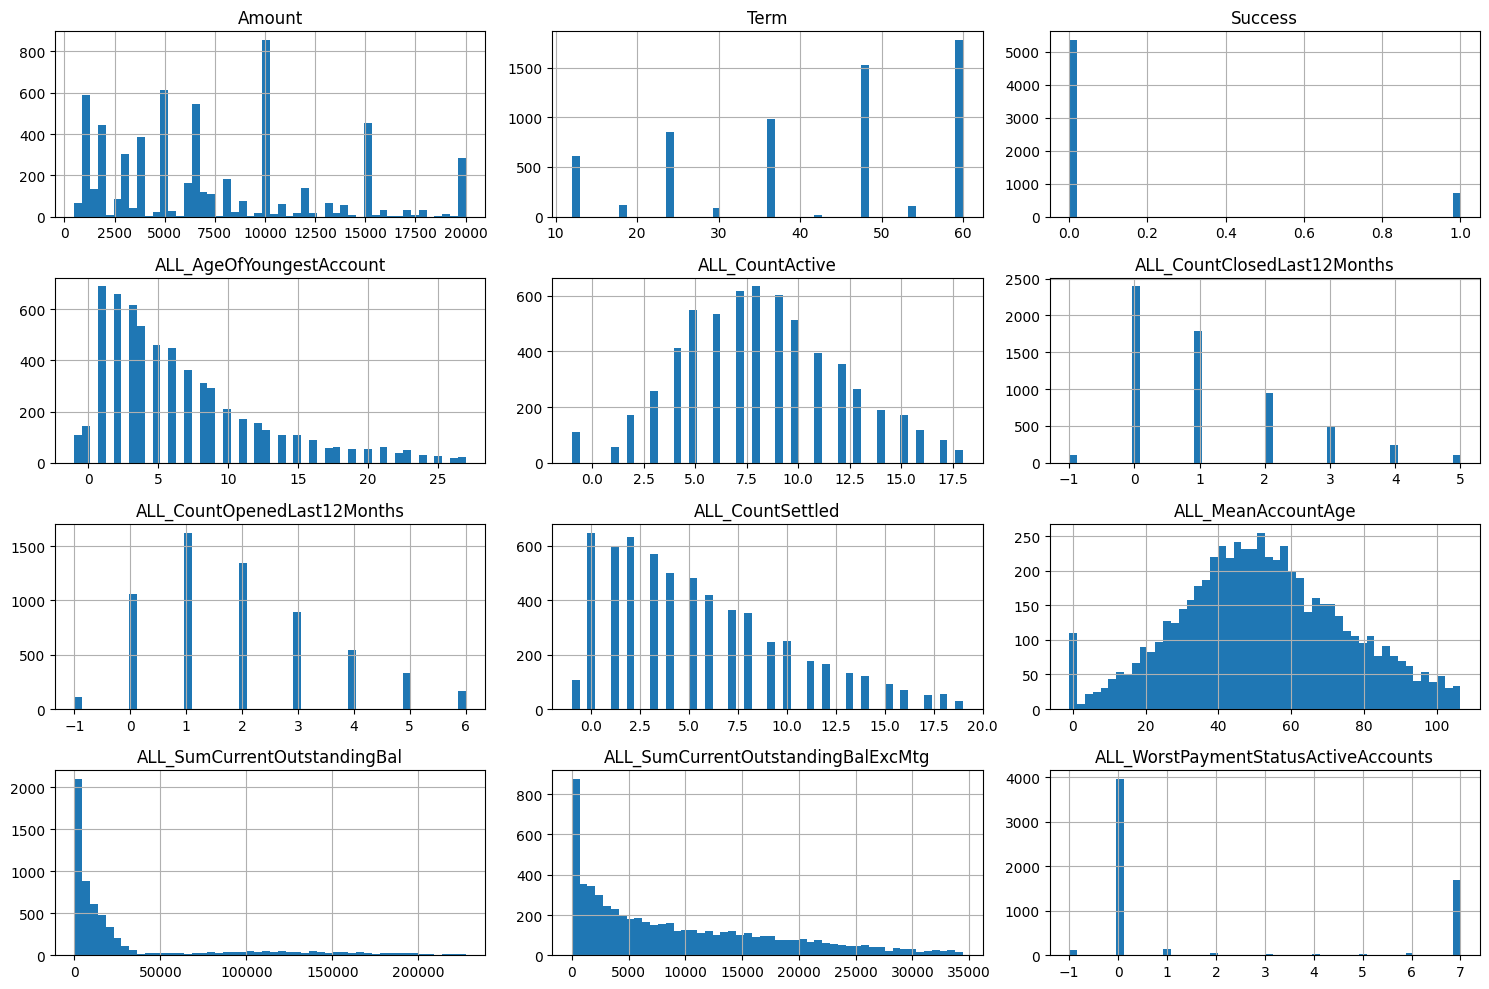

In [39]:
# Заметно, что часть выбросов была удалены
df.hist(bins=50, figsize=(15, 10))
plt.tight_layout()

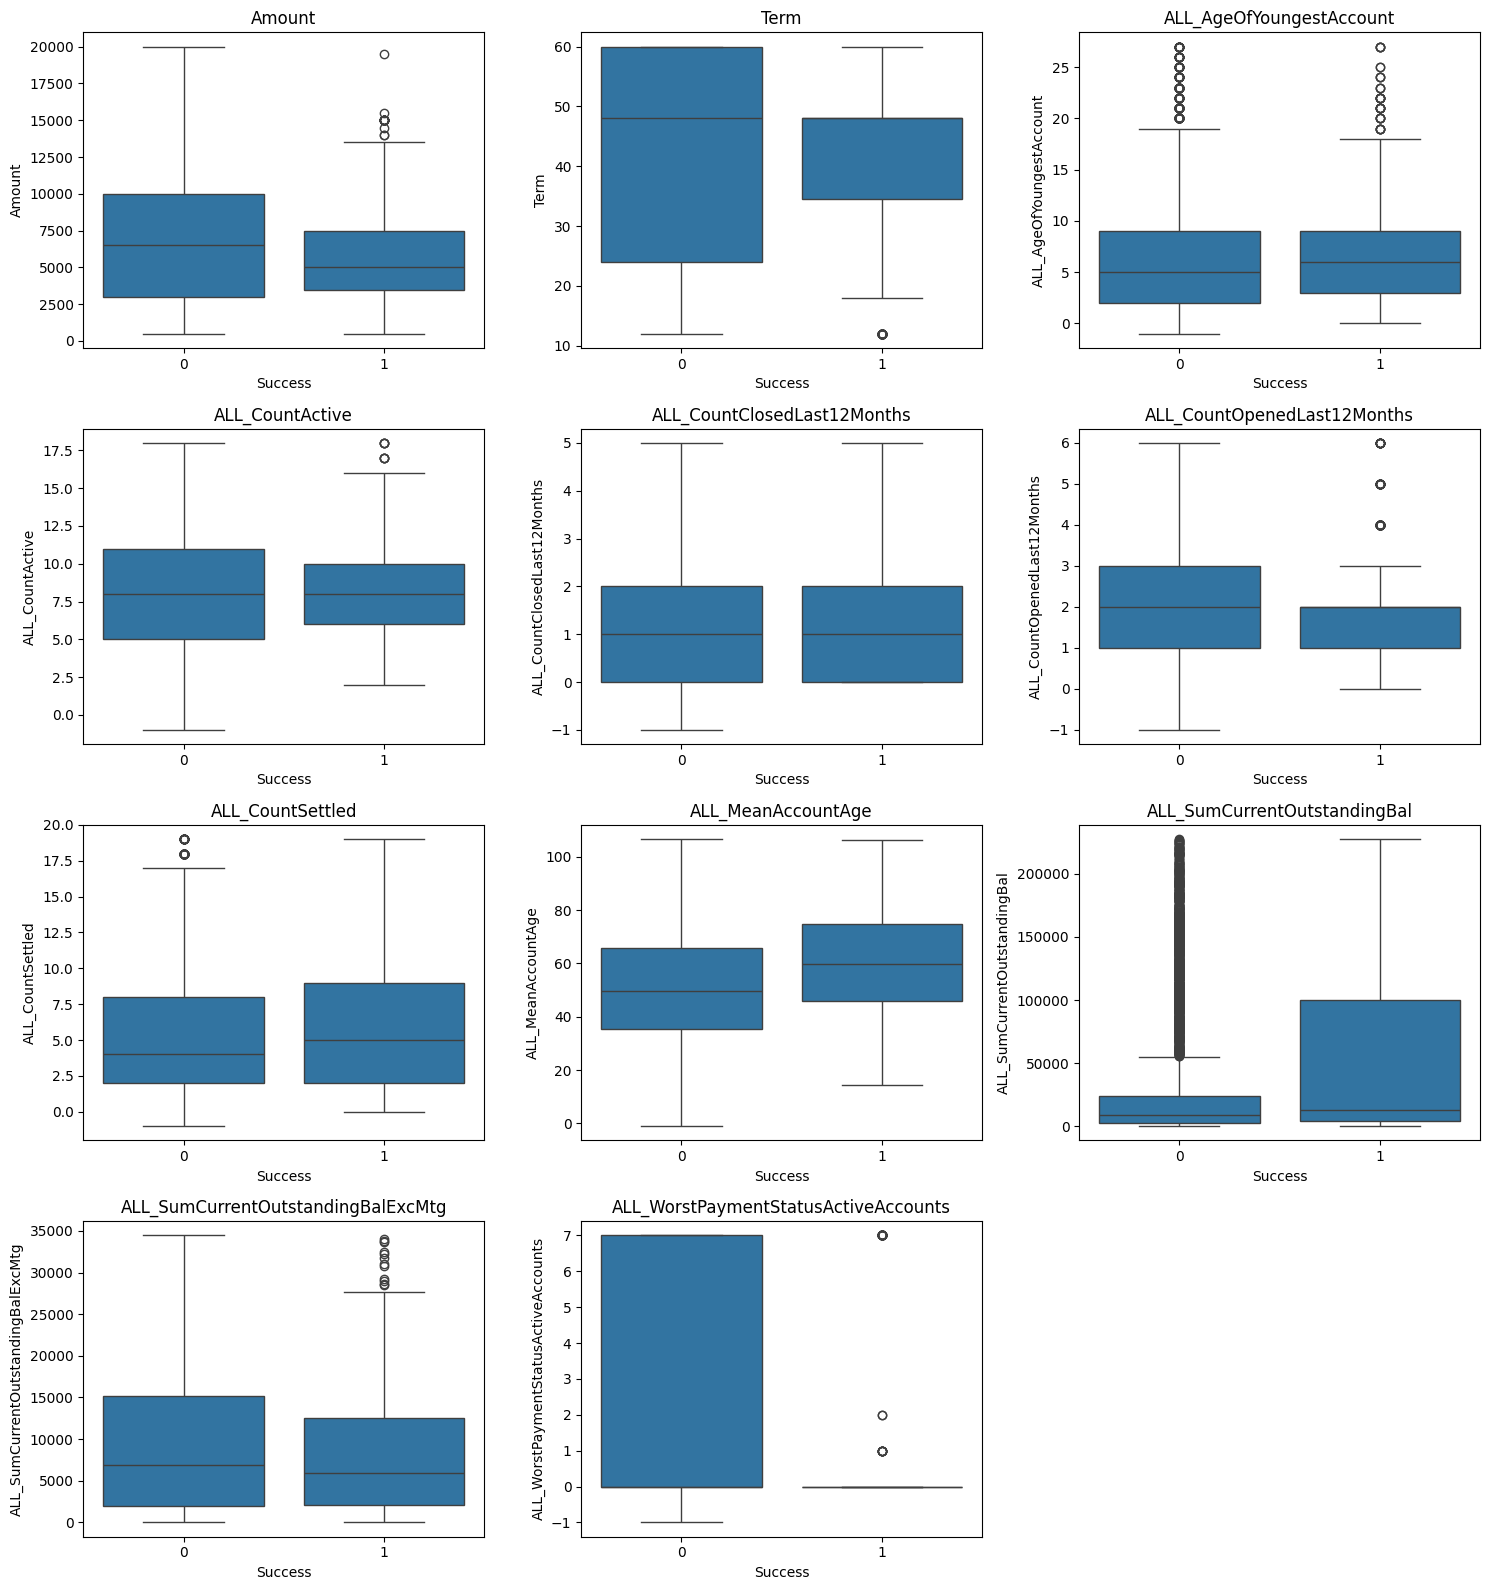

In [42]:
# Строим боксплоты
num_cols = [col for col in df.select_dtypes(include='number').columns if col != 'Success']
n = len(num_cols)

rows = 4
cols = math.ceil(n / rows)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x='Success', y=col, data=df, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [43]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).drop('Success', axis=1).columns.tolist()

# 2. One-hot кодирование категориальных признаков
df = pd.get_dummies(df, columns=cat_cols, drop_first=True).astype(int)

# 3. Разделим на X и y
X = df.drop('Success', axis=1)
y = df['Success']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
df

,Amount,Term,Success,ALL_AgeOfYoungestAccount,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,...,LoanPurpose_pay off debt,LoanPurpose_personal car,LoanPurpose_refurbishment,LoanPurpose_rent,LoanPurpose_repairs,LoanPurpose_short term cash,LoanPurpose_unexpected expense,LoanPurpose_van,LoanPurpose_vehicle,LoanPurpose_wedding
0,2000,60,0,17,12,0,0,6,70,68555,...,0,0,0,0,0,0,0,0,0,0
3,20000,60,0,19,6,1,0,8,67,25738,...,0,0,0,0,0,0,0,0,0,0
6,10000,60,0,6,5,1,1,4,70,900,...,0,0,0,0,0,0,0,0,0,0
7,9000,48,0,2,12,2,2,7,55,157525,...,0,0,0,0,0,0,0,0,0,0
9,15000,54,0,1,10,3,4,15,74,69025,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,5000,60,0,2,16,2,5,6,52,10968,...,0,0,0,0,0,0,0,0,0,1
8843,8000,24,0,20,4,1,0,3,73,2204,...,0,0,0,0,0,0,0,0,0,1
8844,1000,36,0,8,13,0,1,1,44,6786,...,0,0,0,0,0,0,0,0,0,0
8845,10000,60,0,7,3,1,3,1,9,9398,...,0,0,0,0,0,0,0,0,0,1


In [45]:
# # Сохранение данных для тестирования дрейфа признаков
# df.to_csv("original.csv", index=False)

# df_modified = df.copy()
# df_modified['ALL_SumCurrentOutstandingBal'] = df_modified['ALL_SumCurrentOutstandingBal'] * 20
# df_modified.to_csv("modified.csv", index=False)

In [46]:
scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Обучение моделей

## Логистическая регрессия

In [48]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.show()

feature_importances = abs(model.coef_[0])

important_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

              precision    recall  f1-score   support

           0       0.96      0.72      0.83      1071
           1       0.28      0.79      0.41       144

    accuracy                           0.73      1215
   macro avg       0.62      0.76      0.62      1215
weighted avg       0.88      0.73      0.78      1215



## XGBoost

In [49]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1071
           1       0.45      0.18      0.26       144

    accuracy                           0.88      1215
   macro avg       0.67      0.58      0.60      1215
weighted avg       0.84      0.88      0.85      1215



In [50]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")

shap_values = explainer.shap_values(X_test)
mean_importance = np.abs(shap_values).mean(axis=0)

important_features = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': mean_importance
}).sort_values(by='SHAP_Importance', ascending=False)

# SMOTE

## Logistic Regression

In [51]:
smote = SMOTE()
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       0.94      0.78      0.86      1071
           1       0.29      0.66      0.40       144

    accuracy                           0.77      1215
   macro avg       0.62      0.72      0.63      1215
weighted avg       0.87      0.77      0.80      1215



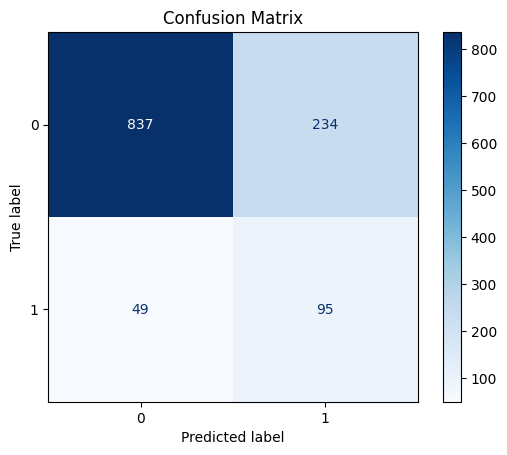

In [52]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## XGBoost

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1071
           1       0.42      0.28      0.34       144

    accuracy                           0.87      1215
   macro avg       0.67      0.62      0.63      1215
weighted avg       0.85      0.87      0.86      1215



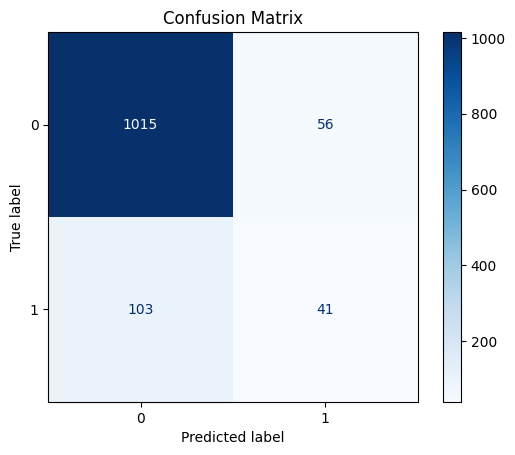

In [53]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [54]:
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

# Подбор гиперпараметров

## Logistic Regression

In [94]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'liblinear',
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
    }

    model = LogisticRegression(**params, max_iter=1000)

    recall = cross_val_score(model, X_train_bal, y_train_bal,
        cv=5, scoring='recall', n_jobs=-1)

    return np.mean(recall)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = LogisticRegression(**best_params, max_iter=1000)
best_model.fit(X_train_bal, y_train_bal)

y_pred = best_model.predict(X_test)

[I 2025-07-19 13:19:12,852] A new study created in memory with name: no-name-5b61bc10-8cd1-4c4b-bdbf-1ab629116ff8
[I 2025-07-19 13:19:14,080] Trial 0 finished with value: 0.8214069946237146 and parameters: {'C': 12.766693104823629, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8214069946237146.
[I 2025-07-19 13:19:14,908] Trial 1 finished with value: 0.820940250166305 and parameters: {'C': 7142727920.035419, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8214069946237146.
[I 2025-07-19 13:19:15,687] Trial 2 finished with value: 0.820940250166305 and parameters: {'C': 251.18012968068328, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8214069946237146.
[I 2025-07-19 13:19:16,010] Trial 3 finished with value: 0.0 and parameters: {'C': 4.363775377225424e-09, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8214069946237146.
[I 2025-07-19 13:19:16,317] Trial 4 finished with value: 0.6981163916727553 a

Лучшие параметры: {'C': 0.21335493900983424, 'penalty': 'l2', 'class_weight': None}
Лучший f1 на валидации: 0.8340050055071483



Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      1071
           1       0.28      0.72      0.41       144

    accuracy                           0.75      1215
   macro avg       0.62      0.74      0.62      1215
weighted avg       0.87      0.75      0.79      1215



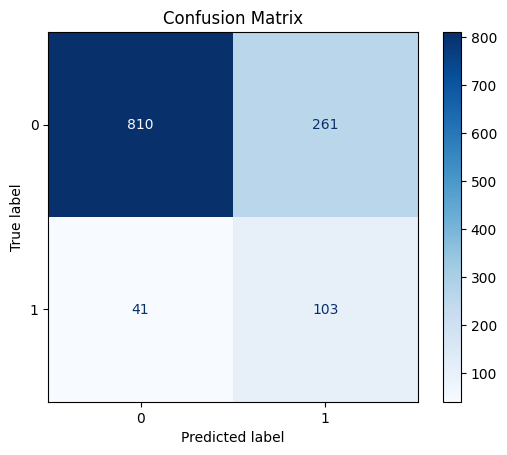

In [95]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## XGBoost

In [104]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'tree_method': 'hist'}

    model = xgb.XGBClassifier(**params)

    recall = cross_val_score(model, X_train_bal, y_train_bal,
                            cv=3, scoring=recall, n_jobs=-1)

    return np.mean(recall)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False,
                               eval_metric='logloss')
best_model.fit(X_train_bal, y_train_bal)

y_pred = best_model.predict(X_test)

[I 2025-07-19 13:24:57,029] A new study created in memory with name: no-name-99b659b2-b4ea-47c8-b01d-2863a9c7e1e7
[I 2025-07-19 13:25:00,714] Trial 0 finished with value: 0.8695204126981562 and parameters: {'n_estimators': 184, 'max_depth': 9, 'learning_rate': 0.14088828840148418, 'subsample': 0.6353764987049534, 'colsample_bytree': 0.8651775464376833, 'min_child_weight': 10, 'gamma': 5.7996390498346475}. Best is trial 0 with value: 0.8695204126981562.
[I 2025-07-19 13:25:03,721] Trial 1 finished with value: 0.8985149704066953 and parameters: {'n_estimators': 188, 'max_depth': 4, 'learning_rate': 0.028204893266041323, 'subsample': 0.5418097756910041, 'colsample_bytree': 0.7083352859629085, 'min_child_weight': 5, 'gamma': 5.7610840409115225}. Best is trial 1 with value: 0.8985149704066953.
[I 2025-07-19 13:25:05,604] Trial 2 finished with value: 0.8751151725324892 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.23075730553113377, 'subsample': 0.6627365674186514,

Лучшие параметры: {'n_estimators': 83, 'max_depth': 9, 'learning_rate': 0.021073607757952983, 'subsample': 0.9988908159080375, 'colsample_bytree': 0.8262489822510573, 'min_child_weight': 4, 'gamma': 5.526717819294646}
Лучший f1 на валидации: 0.906365379231285


In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1071
           1       0.39      0.63      0.49       144

    accuracy                           0.84      1215
   macro avg       0.67      0.75      0.70      1215
weighted avg       0.88      0.84      0.86      1215



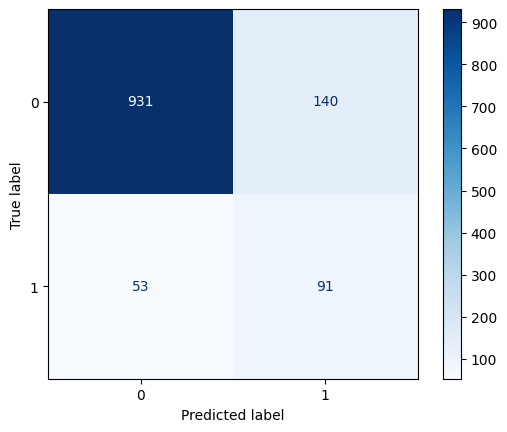

In [106]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
explainer = shap.Explainer(best_model, X_train_bal)
shap_values = explainer(X_test)

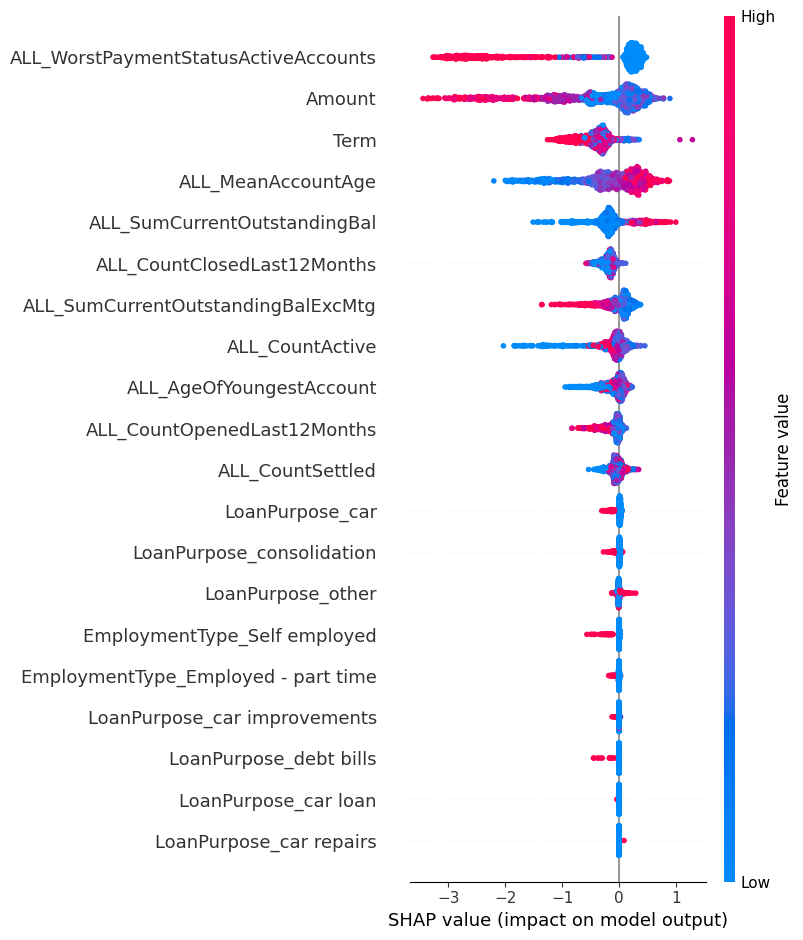

In [66]:
feature_names = X_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [83]:
expected_value = explainer.expected_value
shap.initjs()

id = 7
top10 = np.abs(shap_values[id].values).argsort()[-5:][::-1]
shap.force_plot(expected_value, shap_values[id].values[top10], X_train.iloc[5][top10])

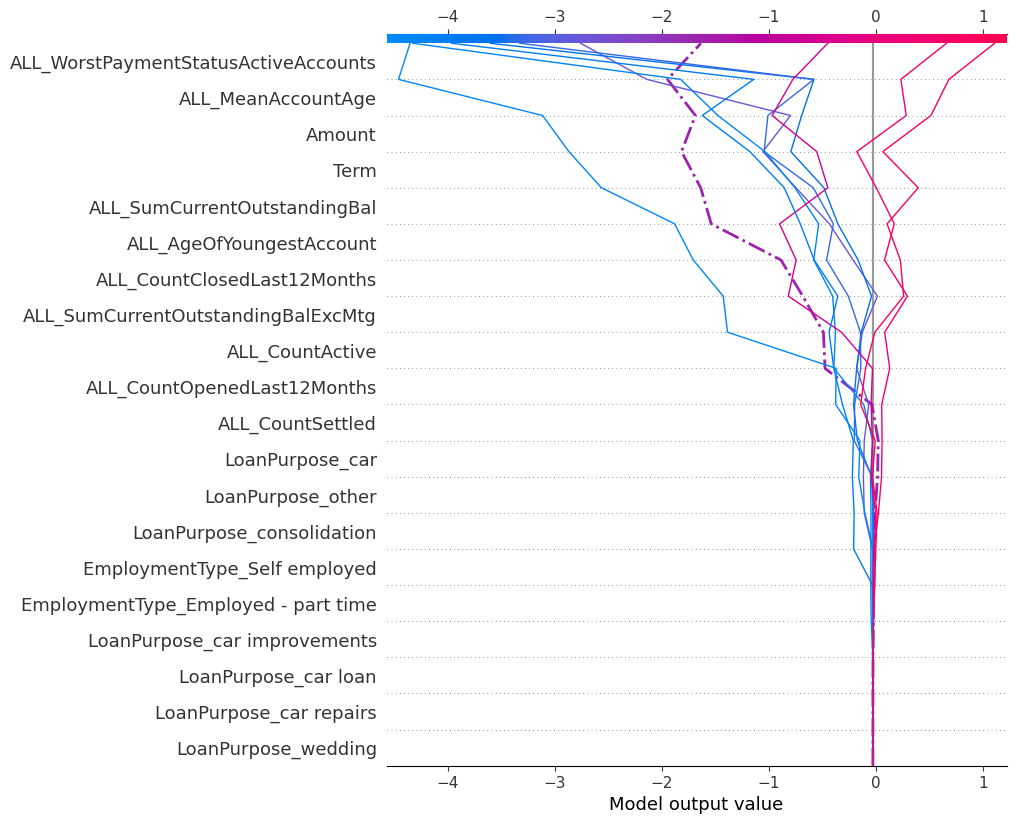

In [90]:
sample_indices = list(range(10))
shap_values_sample = shap_values.values[sample_indices]
features_sample = X_test.iloc[sample_indices]

feature_names = X_test.columns.tolist()

shap.decision_plot(expected_value,
    shap_values_sample,
    features_sample,
    feature_names=feature_names,
    highlight=0)

## TabTransformer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

categorical_columns_filtered = [col for col in X_train.columns if "LoanPurpose_" in col or "EmploymentType_" in col]
continuous_columns_filtered = [col for col in X_train.columns if col not in categorical_columns_filtered]

class TabularDataset(Dataset):
    def __init__(self, continuous, categorical, labels):
        self.continuous = torch.tensor(continuous.values, dtype=torch.float32)
        self.categorical = torch.tensor(categorical.values, dtype=torch.int64)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.continuous[idx], self.categorical[idx], self.labels[idx]

train_dataset = TabularDataset(
    continuous=X_train[continuous_columns_filtered],
    categorical=X_train[categorical_columns_filtered],
    labels=y_train
)
test_dataset = TabularDataset(
    continuous=X_test[continuous_columns_filtered],
    categorical=X_test[categorical_columns_filtered],
    labels=y_test
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Шаг 2: Определение модели TabTransformer

In [44]:
class TabTransformer(pl.LightningModule):
    def __init__(self, num_continuous, num_classes, cat_cardinalities, embed_dim=64, nhead=4, num_layers=8, dropout=0.1):
        super(TabTransformer, self).__init__()
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embed_dim) for cardinality in cat_cardinalities
        ])

        self.layer_norm = nn.LayerNorm(embed_dim)

        transformer_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dropout=dropout)
        self.transformer = TransformerEncoder(transformer_layer, num_layers=num_layers)

        self.fc_continuous = nn.Linear(num_continuous, embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)

        self.attention_pooling = nn.MultiheadAttention(embed_dim, num_heads=4)

        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, continuous, categorical):
        cat_embeddings = [embedding(categorical[:, i]) for i, embedding in enumerate(self.cat_embeddings)]
        cat_embeddings = torch.stack(cat_embeddings, dim=1)
        cat_embeddings = self.layer_norm(cat_embeddings)
        cat_embeddings = self.transformer(cat_embeddings)

        cat_embeddings, _ = self.attention_pooling(cat_embeddings, cat_embeddings, cat_embeddings)
        cat_embeddings = cat_embeddings.mean(dim=1)

        continuous_features = self.fc_continuous(continuous)
        continuous_features = self.gelu(continuous_features)

        combined = cat_embeddings + continuous_features
        output = self.fc_output(combined)
        return output

### Шаг 3: Определение TabTransformerLightning

In [45]:
class TabTransformerLightning(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, continuous, categorical):
        return self.model(continuous, categorical)

    def training_step(self, batch, batch_idx):
        continuous, categorical, labels = batch
        outputs = self(continuous, categorical)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        continuous, categorical, labels = batch
        outputs = self(continuous, categorical)
        preds = outputs.argmax(dim=1)
        loss = self.criterion(outputs, labels)
        fbeta = fbeta_score(labels.cpu(), preds.cpu(), average="binary", beta=2, pos_label=1)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_f2", fbeta, prog_bar=True, on_epoch=True)
        return {"val_loss": loss, "val_f2": fbeta}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)


### Шаг 4: Обучение

In [46]:
tab_transformer_model = TabTransformer(
    num_continuous=len(continuous_columns_filtered),
    num_classes=2,
    cat_cardinalities=[X_train[col].nunique() for col in categorical_columns_filtered]
)

tab_transformer_lightning = TabTransformerLightning(tab_transformer_model)

trainer = pl.Trainer(max_epochs=35)
trainer.fit(tab_transformer_lightning, train_dataloaders=train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | TabTransformer   | 2.3 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.096     Total estimated model params size (MB)
147       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


In [47]:
torch.save(tab_transformer_model.state_dict(), "tab_transformer.pth")

In [52]:
all_preds = []
all_labels = []

tab_transformer_lightning.eval()
with torch.no_grad():
    for batch in test_loader:
        continuous, categorical, labels = batch
        outputs = tab_transformer_lightning(continuous, categorical)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

Confusion Matrix:
[[706 231]
 [ 40  89]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9464    0.7535    0.8390       937
           1     0.2781    0.6899    0.3964       129

    accuracy                         0.7458      1066
   macro avg     0.6123    0.7217    0.6177      1066
weighted avg     0.8655    0.7458    0.7854      1066



## TabTransformer2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

categorical_columns_filtered = [col for col in X_train.columns if "LoanPurpose_" in col or "EmploymentType_" in col]
continuous_columns_filtered = [col for col in X_train.columns if col not in categorical_columns_filtered]

class TabularDataset(Dataset):
    def __init__(self, continuous, categorical, labels):
        self.continuous = torch.tensor(continuous.values, dtype=torch.float32)
        self.categorical = torch.tensor(categorical.values, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.continuous[idx], self.categorical[idx], self.labels[idx]

train_dataset = TabularDataset(
    continuous=X_train[continuous_columns_filtered],
    categorical=X_train[categorical_columns_filtered],
    labels=y_train
)
test_dataset = TabularDataset(
    continuous=X_test[continuous_columns_filtered],
    categorical=X_test[categorical_columns_filtered],
    labels=y_test
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class TabTransformer(LightningModule):
    def __init__(self, num_continuous, num_classes, cat_cardinalities, embed_dim=64, nhead=4, num_layers=8, dropout=0.1):
        super().__init__()
        self.save_hyperparameters()

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embed_dim) for cardinality in cat_cardinalities
        ])
        self.layer_norm = nn.LayerNorm(embed_dim)

        transformer_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dropout=dropout)
        self.transformer = TransformerEncoder(transformer_layer, num_layers=num_layers)

        self.fc_continuous = nn.Linear(num_continuous, embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)

        self.attention_pooling = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, continuous, categorical):
        cat_embeds = [embedding(categorical[:, i]) for i, embedding in enumerate(self.cat_embeddings)]
        cat_embeds = torch.stack(cat_embeds, dim=1)
        cat_embeds = self.layer_norm(cat_embeds)
        cat_embeds = self.transformer(cat_embeds)

        attn_output, _ = self.attention_pooling(cat_embeds, cat_embeds, cat_embeds)
        cat_features = attn_output.mean(dim=1)

        cont_features = self.fc_continuous(continuous)
        cont_features = self.gelu(cont_features)

        combined = cat_features + cont_features
        combined = self.dropout(combined)

        output = self.fc_output(combined)
        return output

    def training_step(self, batch, batch_idx):
        continuous, categorical, labels = batch
        outputs = self(continuous, categorical)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        continuous, categorical, labels = batch
        outputs = self(continuous, categorical)
        preds = torch.argmax(outputs, dim=1)
        loss = self.criterion(outputs, labels)
        f2 = fbeta_score(labels.cpu(), preds.cpu(), average='binary', beta=2, zero_division=0)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f2", f2, prog_bar=True)
        return {"val_loss": loss, "val_f2": f2}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)


tab_transformer_model = TabTransformer(
    num_continuous=len(continuous_columns_filtered),
    num_classes=2,
    cat_cardinalities=[X_train[col].nunique() for col in categorical_columns_filtered]
)

trainer = Trainer(max_epochs=25, logger=CSVLogger("", name="tab_transformer"))
trainer.fit(tab_transformer_model, train_loader, test_loader)

tab_transformer_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for continuous, categorical, labels in test_loader:
        outputs = tab_transformer_model(continuous, categorical)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))